In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from sklearn.model_selection import StratifiedKFold
from torchvision import models
from transformers import Dinov2Model

# device = torch.device('cuda')
if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device("cpu")

from src.train_functions import train_epoch, validate_epoch
from src.preprocess_data import data_preprocess, BiomassDS, create_strata
from src.models import get_dino
from src.transforms_functions import identity_transform, random_flip_transform, tta_transforms
from src.evalaute_functions import evaluate_testds
print(device)

/scratch/k/K.Choi/mypytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# project_dir     = '/Users/k.choi/Documents/github/csiro_git'
# project_dir     = '/Users/kaheichoi/git_repo/csiro_biomass'
project_dir     = os.getcwd()
data_dir        = os.path.join(project_dir, 'data')
model_dir       = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)

csv_data        = pd.read_csv(os.path.join(data_dir, 'train.csv'))
target_names    = csv_data['target_name'].unique()
primary_target  = ['Dry_Green_g','Dry_Total_g','GDM_g'] ### important ordering

In [3]:
# number of fold for stratifiedkfold
n_folds  = 5 
# from long format to wide format 
data = data_preprocess(csv_data, data_dir)
# separate test dataset
train_data, test_data = train_test_split(data, test_size=0.1, random_state=9152)

print(f"train data: {len(train_data)}")
print(f"test data: {len(test_data)}")
# setup kfolds index
kfolds  = create_strata(train_data, target_col='Dry_Total_g', bins = [0, 20, 40, 60, 80, np.inf], n_folds=n_folds)

train data: 321
test data: 36


In [4]:
"""Select dinov2 model"""
dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-small'); patch_dim = 384; model_name = 'dinov2_small'
# dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-base'); patch_dim = 768; model_name = 'dinov2_base'
# dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-large'); patch_dim = 1024; model_name = 'dinov2_large'

dinov2.eval(); dinov2.to(device);

# all_params = sum(p.numel() for p in model.parameters()); print(f"Total parameters: {all_params}")
# train_params = sum(p.numel() for p in model.heads.parameters());print(f"Trainable parameters: {train_params}")
# frozen_params = sum(p.numel() for p in model.backbone.parameters());print(f"Frozen parameters: {frozen_params}")

In [5]:
""" PARAMETERS """

NUM_EPOCHS = 100
mean = [0.485, 0.456, 0.406] # mean for normalization transform of dinov2
std  = [0.229, 0.224, 0.225] # std for normalization transform of dinov2
BATCH_SIZE = 16 
# number of worker is 4 for cuda, 0 for mps and cpu
NUM_WORKERS = 8 # CPU requirement > 4 for A40 to avoid bottleneck

WEIGHT_DECAY = 1e-4 # weight decay for optimizer
EARLY_STOPPING_PATIENCE = 10 # early stopping
LR = 1e-3 
LR_PATIENCE = 5
LR_FACTOR = 0.5 # factor to scale learning weight

""" Check cuda avaliable """
if torch.cuda.is_available(): WORKERS = NUM_WORKERS
else: WORKERS = 0


""" MEAN SQUARE ERROR LOSS """
criterion = nn.MSELoss() 

""" TRANSFORMS """
# resize -> horizontal flip (p=0.5) -> vertical flip (p=.05) -> to_tensor -> normalization
train_transform = random_flip_transform(mean, std) 
# resize -> to_tensor -> normalization
valid_transform = identity_transform(mean, std)


In [7]:
""" TRAINING """

fold_model, fold_history, fold_best_rmses = [], [], []

for fold_idx, (train_idx, val_idx) in enumerate(kfolds):
    best_epoch, epoch_counts, best_val, best_model = 0, 0, float('inf'), None
    
    model     = get_dino(dinov2, patch_dim=patch_dim, num_targets=3); model.to(device) 
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience= LR_PATIENCE)

    # get strata from kfold method
    train_fold = train_data.iloc[train_idx]
    valid_fold = train_data.iloc[val_idx]

    train_ds     = BiomassDS(df =train_fold, data_dir =data_dir, transform = train_transform, target_names=primary_target) ### ouptut : green , total, gdm
    valid_ds     = BiomassDS(df =valid_fold, data_dir =data_dir, transform = valid_transform, target_names=primary_target) ### output : green , total, gdm

    # pin_memory is deactivated if cuda is not used
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True  , pin_memory= device == torch.cuda.is_available())
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=False , pin_memory= device == torch.cuda.is_available())
 

    history = {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'pre_target_rmse': [], 'learning_rate': []}
    for epoch in range(NUM_EPOCHS):
        train_loss                              = train_epoch(model, train_loader, optimizer, criterion, device)
        valid_loss, rmse, all_preds, all_targs  = validate_epoch(model, valid_loader, criterion, device)

        scheduler.step(valid_loss)
        current_lr = optimizer.param_groups[0]['lr']

        per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
        
        """ update history """
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['val_rmse'].append(rmse)
        history['learning_rate'].append(current_lr)
        history['pre_target_rmse'].append(per_target_rmse) 

        if epoch % 10 == 0:
            print(f"\nFold: {fold_idx}: Epoch {epoch}/{NUM_EPOCHS}"); print(32 * " -")  
            print(f"  train loss: {train_loss:.1f}")
            print(f"  valid loss: {valid_loss:.1f}")
            print(f"  rmse: {rmse:.1f}") 
            print(f"  lr: {current_lr:.6f}")
            print(f"  per target rmse: {per_target_rmse}")
        if valid_loss < best_val:
            print(f"val_loss improved from {best_val:.1f} to {valid_loss:.1f} at epoch {epoch+1} since epoch {best_epoch+1}")
            best_val, best_epoch, epoch_counter, best_model = valid_loss, epoch, 0, model.state_dict()  
            torch.save(best_model, os.path.join(model_dir, f'best_model_{model_name}_fold{fold_idx}.pth'))
        else: epoch_counter += 1;
        if epoch_counter >= EARLY_STOPPING_PATIENCE: print(f"Early stopping at epoch {epoch+1} at valid_loss : {best_val:.1f}"); break

    fold_model.append(model)
    fold_history.append(history)
    fold_best_rmses.append(best_val)


    print(f"Fold {fold_idx} completed"); print(32 * " -")


Fold: 0: Epoch 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1701.2
  valid loss: 1572.3
  rmse: 42.9
  lr: 0.001000
  per target rmse: [37.003475 50.804115 39.68798 ]
val_loss improved from inf to 1572.3441 at epoch 1 since epoch 1
val_loss improved from 1572.3441 to 1450.7734 at epoch 2 since epoch 1
val_loss improved from 1450.7734 to 1330.2149 at epoch 3 since epoch 2
val_loss improved from 1330.2149 to 1218.0343 at epoch 4 since epoch 3
val_loss improved from 1218.0343 to 1118.4332 at epoch 5 since epoch 4
val_loss improved from 1118.4332 to 1030.1535 at epoch 6 since epoch 5
val_loss improved from 1030.1535 to 958.0575 at epoch 7 since epoch 6
val_loss improved from 958.0575 to 896.0133 at epoch 8 since epoch 7
val_loss improved from 896.0133 to 849.1905 at epoch 9 since epoch 8
val_loss improved from 849.1905 to 790.0240 at epoch 10 since epoch 9

Fold: 0: Epoch 10/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  trai

In [8]:
"""  SAVE HISTORY """
for fold_idx, histories in enumerate(fold_history):
    history_pd = pd.DataFrame(histories)
    history_pd.to_csv(os.path.join(model_dir, f'history_{model_name}_fold_{fold_idx}.csv'), index=False)        

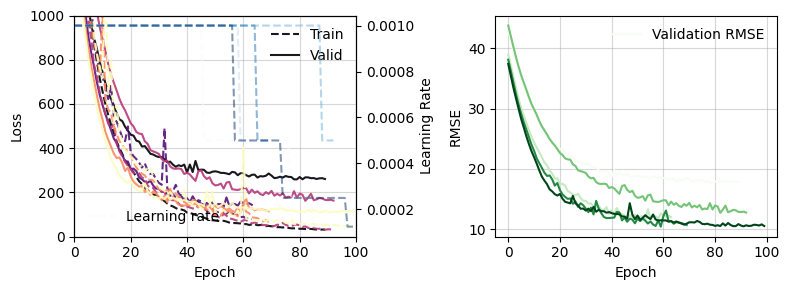

In [28]:
""" PLOT HISTORY """

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()
ax1  = axes[0].twinx()
Reds = sns.color_palette("magma", as_cmap=True)
Greens = sns.color_palette("Greens", as_cmap=True)
Blues = sns.color_palette("Blues", as_cmap=True)

crange = np.linspace(0, 1, n_folds)

try: 
    fold_history[n_folds-1]
except:
    fold_history =[] 
    for idx in range(n_folds):
        fold_history.append( pd.read_csv(os.path.join(model_dir, f'history_{model_name}_fold_{idx}.csv')) )

for idx, histories in enumerate(fold_history):  
    if idx == 0:
        axes[0].plot(histories['train_loss'], label='Train', c=Reds(crange[idx]), ls = '--', alpha=0.9)
        axes[0].plot(histories['valid_loss'], label='Valid', c=Reds(crange[idx]), ls = '-' , alpha=0.9) 
        axes[1].plot(histories['val_rmse'], label='Validation RMSE', c=Greens(crange[idx]))
        ax1.plot(histories['learning_rate'], label='Learning rate', c=Blues(crange[idx]), ls='--', alpha=0.5)
    
        axes[0].legend(loc='upper right', frameon=False)
        axes[1].legend(loc='upper right', frameon=False)
        ax1.legend(loc='lower left', frameon=False) 
    else :
        axes[0].plot(histories['train_loss'], c=Reds(crange[idx]), ls = '--', alpha=0.9)
        axes[0].plot(histories['valid_loss'], c=Reds(crange[idx]), alpha=0.9)
        ax1.plot(histories['learning_rate'],  c=Blues(crange[idx]), ls='--', alpha=0.5)
        axes[1].plot(histories['val_rmse'],   c=Greens(crange[idx]))
    
    idx += 1
    
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 1000)

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('RMSE')
ax1.set_ylabel('Learning Rate')
axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')
ax1.set_xlabel('Epoch')
axes[0].grid(True,alpha=0.5)
axes[1].grid(True,alpha=0.5) 
plt.tight_layout()
plt.show()


In [10]:
data.describe()

,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,12.044548,26.624722,45.318097,33.274414
std,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,3.200000,8.800000,25.271500,16.026100
50%,1.423500,7.980900,20.800000,40.300000,27.108200
75%,7.242900,17.637800,35.083400,57.880000,43.675700
max,71.786500,83.840700,157.983600,185.700000,157.983600


In [ ]:
""" TIME TESTED AUGMENTATION """

fold_preds , targ_lists = [], []

tta = tta_transforms()
tta_list = tta.get_transforms()

for fold_idx in range(n_folds):
    model = get_din
    o(dinov2, patch_dim=patch_dim, num_targets=3); model.to(device) 
    model.load_state_dict(torch.load(os.path.join(model_dir, f'best_model_{model_name}_fold{fold_idx}.pth')))
    model.eval();
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience= LR_PATIENCE)


    tta_preds = []
    
    for tta_idx , (tta_name, tta_transform) in enumerate(tta_list):
        test_ds = BiomassDS(test_data, data_dir, tta_transform, primary_target)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

        pred_list, targ_list = evaluate_testds(model, test_loader, device)
        tta_preds.append(pred_list) 
    fold_preds.append( np.mean(np.array(tta_preds), axis=0) ) 

Testing: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

for j , p in enumerate(fold_preds):
    metric_data = [] 
    
    for i , tar in enumerate(primary_target):
        y_true, y_pred = targ_list[:,i], p[:,i]
        
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        
        metric_data.append({ 'target': tar, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2})
    
    metric_data.append({
        'target' : 'overall', 
        'mae': mean_absolute_error(targ_list.flatten(), p.flatten()), 
        'mse': mean_squared_error(targ_list.flatten(), p.flatten()), 
        'rmse': np.sqrt(mean_squared_error(targ_list.flatten(), p.flatten())), 
        'r2': r2_score(targ_list.flatten(), p.flatten())})
    
    metric_df = pd.DataFrame(metric_data)
    display(metric_df)

,target,mae,mse,rmse,r2
0,Dry_Green_g,9.233532,182.915894,13.524640,0.647710
1,Dry_Total_g,14.387244,401.740204,20.043458,0.523171
2,GDM_g,9.910216,199.312759,14.117817,0.591142
3,overall,11.176997,261.322968,16.165487,0.620097


,target,mae,mse,rmse,r2
0,Dry_Green_g,8.162824,173.785400,13.182769,0.665295
1,Dry_Total_g,14.154126,401.615540,20.040348,0.523319
2,GDM_g,8.950488,191.793381,13.848949,0.606567
3,overall,10.422480,255.731430,15.991605,0.628226


,target,mae,mse,rmse,r2
0,Dry_Green_g,8.278970,178.221039,13.349945,0.656752
1,Dry_Total_g,12.452485,322.652740,17.962537,0.617041
2,GDM_g,8.826809,176.594849,13.288899,0.637744
3,overall,9.852755,225.822922,15.027406,0.671706


,target,mae,mse,rmse,r2
0,Dry_Green_g,9.917966,241.490860,15.539976,0.534896
1,Dry_Total_g,15.878331,474.566406,21.784545,0.436733
2,GDM_g,11.564027,264.088379,16.250796,0.458265
3,overall,12.453442,326.715210,18.075265,0.525032


,target,mae,mse,rmse,r2
0,Dry_Green_g,8.380497,190.347778,13.796658,0.633396
1,Dry_Total_g,13.092690,350.292847,18.716112,0.584235
2,GDM_g,8.821922,189.150146,13.753187,0.611989
3,overall,10.098371,243.263565,15.596909,0.646351


/scratch-local/slurm-job-tmp-11788553/ipykernel_4605/2246935125.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[i].scatter(y_true, y_pred, alpha=1, c=Reds(crange[j]), s= 20, lw=0.7)


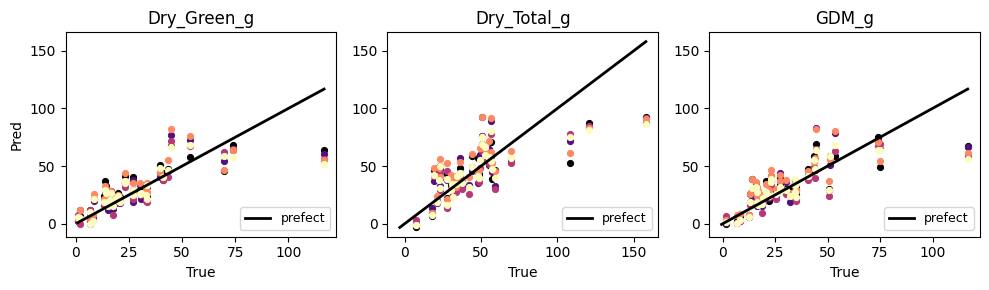

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for j, pred_lists in enumerate(fold_preds):
    
    for i , tar in enumerate(primary_target):

        y_true, y_pred = targ_list[:,i], pred_lists[:,i]
        
        axes[i].scatter(y_true, y_pred, alpha=1, c=Reds(crange[j]), s= 20, lw=0.7)
        if i>0: axes[i].sharey(axes[0]);
        else : axes[i].set_ylabel('Pred')
        if j ==0:
            min_val = min(min(y_true), min(y_pred))
            max_val = max(max(y_true), max(y_pred))
            axes[i].set_xlabel('True')
            axes[i].set_title(f'{tar}')
            axes[i].plot([min_val, max_val], [min_val, max_val], c= 'k', lw=2, label = 'prefect')
            axes[i].legend(loc = 'lower right', fontsize = 9)
plt.tight_layout(); plt.show()
    